In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn


%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../../')
# import utils
from VisUtils import *
from split_data import *
from RF_Utils import *
# from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz


In [2]:
def plot_metrics_for_models(results_list, dataset_title):
    """for testing"""
    plt.figure(figsize=(10, 6))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
 
    metric_values = np.zeros((num_models, num_metrics))
    for i, results in enumerate(results_list):
        for j, metric in enumerate(metrics):
            metric_values[i, j] = results['test_'+metric]
    bar_width = 0.15
    index = np.arange(num_models)
    plt.figure(figsize=(10, 6))
    for i in range(num_metrics):
        plt.bar(index + i * bar_width, metric_values[:, i], bar_width, label=metrics[i])

    plt.xlabel('Model Types')
    plt.ylabel('Values')
    plt.title(f'Metrics Across Model Types: {dataset_title}')
    plt.xticks(index + bar_width *(num_metrics - 1)/2, model_names)
    plt.legend()
    plt.show()

In [3]:
def plot_metrics_for_sampling(results_list, dataset_title):
    """for testing"""
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)
    metric_values = np.zeros((num_models, num_metrics))
    bar_width = 0.15
    index = np.arange(num_models)

    for i in range(num_datasets):
        plt.subplot(num_datasets, 1, i+1)
        metric_values = np.zeros((num_models, num_metrics))
        for j, results in enumerate(results_lists[i]):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Model Types')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Model Types: {dataset_titles[i]}')
        plt.xticks(index + bar_width *(num_metrics -1)/2, model_names)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show(); 

In [4]:
def plot_metrics_for_models2(results_lists, titles):
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)

    bar_width = 0.15
    index = np.arange(num_models)
    for i in range(num_models):
        plt.subplot(num_models, 1, i+1)
        metric_values = np.zeros((num_datasets, num_metrics))
        for j, results_list in enumerate(results_lists):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results_list[i]['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Sampling Techniques')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Sampling Techniques for Model Type: {model_names[i]}')
        plt.xticks(index + bar_width * (num_metrics - 1) / 2, dataset_titles)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show();


In [5]:
def plot_chosen_metric(results_lists, metric, title):
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    sampling_techniques = ['Original', 'Undersampled', 'SMOTE', 'ADASYN']
    # metrics = ['acc', 'prec', 'recall', 'specificity']
    plt.figure(figsize=(10, 6))
    # for i, model_name in enumerate(model_names):
    #     metric_values = []
    #     for j, results_list in enumerate(results_lists):
    #         metric_values.append(results_list[j]['test_'+metric])

    #     plt.plot(sampling_techniques, metric_values, label=model_name)
    for i, model_results in enumerate(results_lists):
        metric_values = [result['test_'+metric] for result in model_results]
        plt.plot(sampling_techniques, metric_values, label=model_names[i])
    plt.xlabel('Sampling type')
    plt.ylabel('Value')
    plt.title(f'{metric} Results: {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
modeldir = '../saved_models/'

# Load datasets
(MOE descriptors, just scaled)

In [7]:
split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/bind/'
train_x_df = pd.read_csv(split_path + 'bind_train_x_scaledoriginal.csv', header=None)
train_y_df = pd.read_csv(split_path + 'bind_train_y_scaledoriginal.csv', header=None)
test_y_df = pd.read_csv(split_path + 'bind_test_y_scaledoriginal.csv', header=None)
test_x_df = pd.read_csv(split_path + 'bind_test_x_scaledoriginal.csv', header=None)
train_x = train_x_df.values
train_y = train_y_df.values.flatten()
test_y = test_y_df.values.flatten()
test_x = test_x_df.values
train_x.shape, train_y.shape, test_y.shape, test_x.shape

((1125, 306), (1125,), (283,), (283, 306))

In [10]:
counttrain = np.count_nonzero(train_y == 1)
counttest = np.count_nonzero(test_y == 1)
counttrain, counttest

(45, 12)

In [16]:
# UNDER 
train_x_df_UNDER = pd.read_csv(split_path + 'bind_train_x_UNDER.csv', header=None)
train_y_df_UNDER = pd.read_csv(split_path + 'bind_train_y_UNDER.csv', header=None)
test_y_df_UNDER = pd.read_csv(split_path + 'bind_test_y_UNDER.csv', header=None)
test_x_df_UNDER = pd.read_csv(split_path + 'bind_test_x_UNDER.csv', header=None)
train_x_UNDER = train_x_df_UNDER.values
train_y_UNDER = train_y_df_UNDER.values.flatten()
test_y_UNDER= test_y_df_UNDER.values.flatten()
test_x_UNDER = test_x_df_UNDER.values
print(train_x_UNDER.shape, train_y_UNDER.shape, test_x_UNDER.shape, test_y_UNDER.shape)

(90, 306) (90,) (283, 306) (283,)


(45, 12)

In [17]:
# SMOTE 
train_x_df_SMOTE = pd.read_csv(split_path + 'bind_train_x_SMOTE.csv', header=None)
train_y_df_SMOTE = pd.read_csv(split_path + 'bind_train_y_SMOTE.csv', header=None)
test_y_df_SMOTE = pd.read_csv(split_path + 'bind_test_y_SMOTE.csv', header=None)
test_x_df_SMOTE = pd.read_csv(split_path + 'bind_test_x_SMOTE.csv', header=None)
train_x_SMOTE = train_x_df_SMOTE.values
train_y_SMOTE = train_y_df_SMOTE.values.flatten()
test_y_SMOTE= test_y_df_SMOTE.values.flatten()
test_x_SMOTE = test_x_df_SMOTE.values
print(train_x_SMOTE.shape, train_y_SMOTE.shape, test_x_SMOTE.shape, test_y_SMOTE.shape)

(2160, 306) (2160,) (283, 306) (283,)


In [18]:
# ADASYN
train_x_df_ADASYN = pd.read_csv(split_path + 'bind_train_x_ADASYN.csv', header=None)
train_y_df_ADASYN = pd.read_csv(split_path + 'bind_train_y_ADASYN.csv', header=None)
test_y_df_ADASYN = pd.read_csv(split_path + 'bind_test_y_ADASYN.csv', header=None)
test_x_df_ADASYN = pd.read_csv(split_path + 'bind_test_x_ADASYN.csv', header=None)
train_x_ADASYN = train_x_df_ADASYN.values
train_y_ADASYN = train_y_df_ADASYN.values.flatten()
test_y_ADASYN= test_y_df_ADASYN.values.flatten()
test_x_ADASYN = test_x_df_ADASYN.values
print(train_x_ADASYN.shape, train_y_ADASYN.shape, test_x_ADASYN.shape, test_y_ADASYN.shape)

(2158, 306) (2158,) (283, 306) (283,)


In [24]:
counttrain = np.count_nonzero(train_y == 1)
counttest = np.count_nonzero(test_y == 1)
print(f'normal: {counttrain}/{train_x.shape[0]}, {counttest}/{test_x.shape[0]}')

trainUNDER = np.count_nonzero(train_y_UNDER == 1)
testUNDER = np.count_nonzero(test_y_UNDER == 1)
print(f'UNDER: {trainUNDER}/{train_x_UNDER.shape[0]}, {testUNDER}/{test_x_UNDER.shape[0]}')

trainSMOTE = np.count_nonzero(train_y_SMOTE == 1)
testSMOTE = np.count_nonzero(test_y_SMOTE == 1)
print(f'SMOTE: {trainSMOTE}/{train_x_SMOTE.shape[0]}, {testSMOTE}/{test_x_SMOTE.shape[0]}')


trainADASYN = np.count_nonzero(train_y_ADASYN == 1)
testADASYN = np.count_nonzero(test_y_ADASYN == 1)
print(f'ADASYN: {trainADASYN}/{train_x_ADASYN.shape[0]}, {testADASYN}/{test_x_ADASYN.shape[0]}')

normal: 45/1125, 12/283
UNDER: 45/90, 12/283
SMOTE: 1080/2160, 12/283
ADASYN: 1078/2158, 12/283


In [25]:
12/283

0.04240282685512368

{'default_RF':rf_basic100estUNDER['model'], 'rf_bcw':brf_model_BCW_UNDER['model'],
                              'BRFC':brf_modelUNDER['model'], 'BRFC_bcw':brf_modelCWB_UNDER['model']}
 temp_nek2bind_MOE_SMOTE = {'default_RF':rf_basic100estSMOTE['model'],
                            'rf_bcw':brf_model_BCW_SMOTE['model'],
                             'BRFC': brf_modelSMOTE['model'],
                            'BRFC_bcw':brf_modelCWB_SMOTE['model']}
 temp_nek2bind_MOE_ADASYN = {'default_RF':rf_basic100estADASYN['model'],
                            'rf_bcw':brf_model_BCW_ADASYN['model'],
                             'BRFC': brf_modelADASYN['model'],
                            'BRFC_bcw':brf_modelCWB_ADASYN['model']} -->

In [129]:
# filenames = ['temp_nek2bind_originalmodels.pkl', 'temp_nek2bind_originalUNDERmodels.pkl',
#              'temp_nek2bind_SMOTEmodels.pkl', 'temp_nek2bind_ADASYNmodels.pkl'] 
# grid search best estimators 
filenames = ['../nek2bind_originalmodels.pkl','../nek2bind_UNDERmodels.pkl',
             '../nek2bind_SMOTEmodels.pkl', '../nek2bind_ADASYNmodels.pkl']
bind_models = [] 
for i, val in enumerate(filenames):
    with open(filenames[i], 'rb') as f: 
        model = pickle.load(f)
    bind_models.append(model)
bind_original = bind_models[0] 
bind_under = bind_models[1] 
bind_smote = bind_models[2] 
bind_adasyn = bind_models[3] 

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [130]:
saved_results = []
default_results = []
defaultbcw_results =[] 
brfc_results = []
brfcbcw_results = [] 
results_original1=[]
results_under1 = [] 
results_smote1 = []
results_adasyn1 =[]
recalls = []
dataset_type_results = ['default_RF','rf_bcw', 'BRFC','BRFC_bcw' ]
results_files = ['../nek2_bind_original_results.pkl','../nek2_bind_UNDER_results.pkl','../nek2_bind_SMOTE_results.pkl','../nek2_bind_ADASYN_results.pkl']


TRAIN: accuracy: 0.974, precision: 0.786, recall: 0.489, specificity: 0.994
TEST: accuracy: 0.947, precision: 0.000, recall: 0.000, specificity: 0.989
TRAIN: accuracy: 0.998, precision: 0.957, recall: 1.000, specificity: 0.998
TEST: accuracy: 0.940, precision: 0.222, recall: 0.167, specificity: 0.974
TRAIN: accuracy: 0.716, precision: 0.124, recall: 1.000, specificity: 0.705
TEST: accuracy: 0.724, precision: 0.098, recall: 0.667, specificity: 0.727
TRAIN: accuracy: 0.735, precision: 0.131, recall: 1.000, specificity: 0.724
TEST: accuracy: 0.739, precision: 0.092, recall: 0.583, specificity: 0.745


<Figure size 1000x600 with 0 Axes>

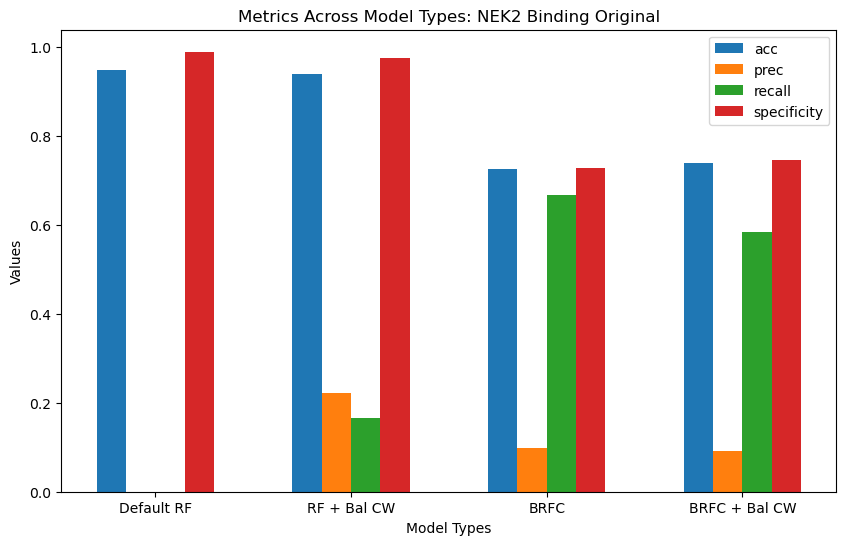

In [131]:
# do each model type: default rf, rf+bal cw, brfc, brfc+bal cw
bind_original_results = [] 
for model_type, model in bind_original.items():
    results = rf_results2(model, train_x, train_y, test_x, test_y)
    bind_original_results.append(results)
plot_metrics_for_models(bind_original_results, 'NEK2 Binding Original')

TRAIN: accuracy: 0.733, precision: 0.657, recall: 0.978, specificity: 0.489
TEST: accuracy: 0.657, precision: 0.079, recall: 0.667, specificity: 0.657
TRAIN: accuracy: 0.733, precision: 0.657, recall: 0.978, specificity: 0.489
TEST: accuracy: 0.643, precision: 0.076, recall: 0.667, specificity: 0.642
TRAIN: accuracy: 0.744, precision: 0.667, recall: 0.978, specificity: 0.511
TEST: accuracy: 0.657, precision: 0.079, recall: 0.667, specificity: 0.657
TRAIN: accuracy: 0.989, precision: 0.978, recall: 1.000, specificity: 0.978
TEST: accuracy: 0.640, precision: 0.098, recall: 0.917, specificity: 0.627


<Figure size 1000x600 with 0 Axes>

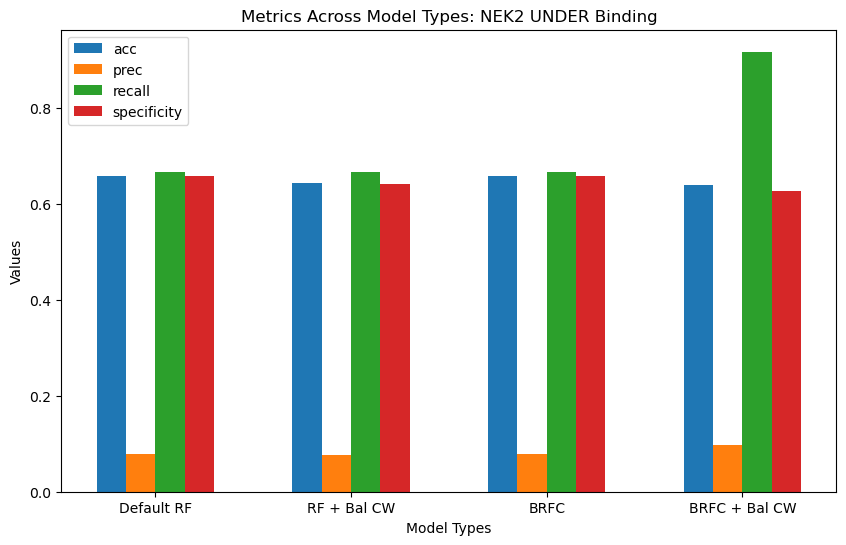

In [132]:
bind_under_results = [] 
for model_type, model in bind_under.items():
    results = rf_results2(model, train_x_UNDER, train_y_UNDER, test_x_UNDER, test_y_UNDER)
    bind_under_results.append(results)
plot_metrics_for_models(bind_under_results, 'NEK2 UNDER Binding')

TRAIN: accuracy: 0.995, precision: 1.000, recall: 0.991, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.222, recall: 0.333, specificity: 0.948
TRAIN: accuracy: 0.995, precision: 1.000, recall: 0.991, specificity: 1.000
TEST: accuracy: 0.919, precision: 0.211, recall: 0.333, specificity: 0.945
TRAIN: accuracy: 0.997, precision: 1.000, recall: 0.994, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.250, recall: 0.417, specificity: 0.945
TRAIN: accuracy: 0.995, precision: 1.000, recall: 0.991, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.222, recall: 0.333, specificity: 0.948


<Figure size 1000x600 with 0 Axes>

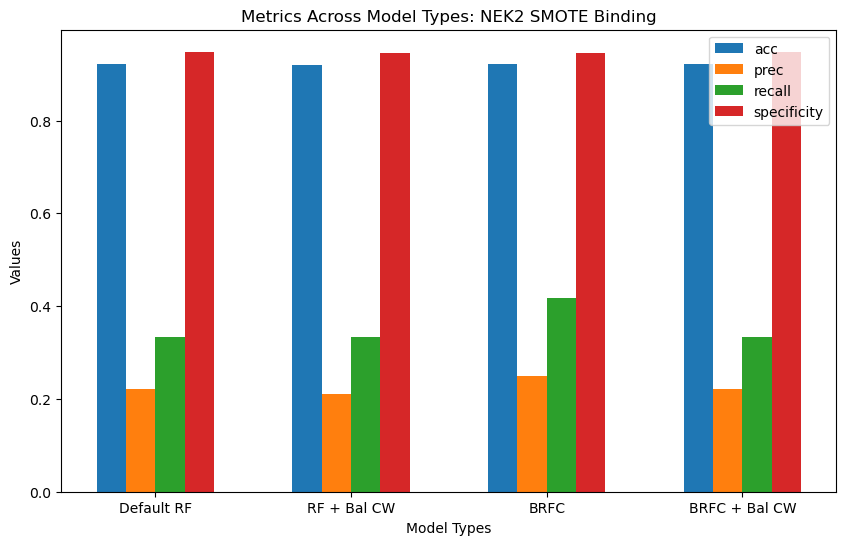

In [113]:
bind_smote_results = [] 
for model_type, model in bind_smote.items():
    results = rf_results2(model, train_x_SMOTE, train_y_SMOTE, test_x_SMOTE, test_y_SMOTE)
    bind_smote_results.append(results)
plot_metrics_for_models(bind_smote_results, 'NEK2 SMOTE Binding')

TRAIN: accuracy: 0.991, precision: 0.999, recall: 0.982, specificity: 0.999
TEST: accuracy: 0.922, precision: 0.222, recall: 0.333, specificity: 0.948
TRAIN: accuracy: 0.992, precision: 0.993, recall: 0.991, specificity: 0.993
TEST: accuracy: 0.912, precision: 0.190, recall: 0.333, specificity: 0.937
TRAIN: accuracy: 0.995, precision: 1.000, recall: 0.991, specificity: 1.000
TEST: accuracy: 0.929, precision: 0.250, recall: 0.333, specificity: 0.956
TRAIN: accuracy: 0.995, precision: 1.000, recall: 0.991, specificity: 1.000
TEST: accuracy: 0.933, precision: 0.267, recall: 0.333, specificity: 0.959


<Figure size 1000x600 with 0 Axes>

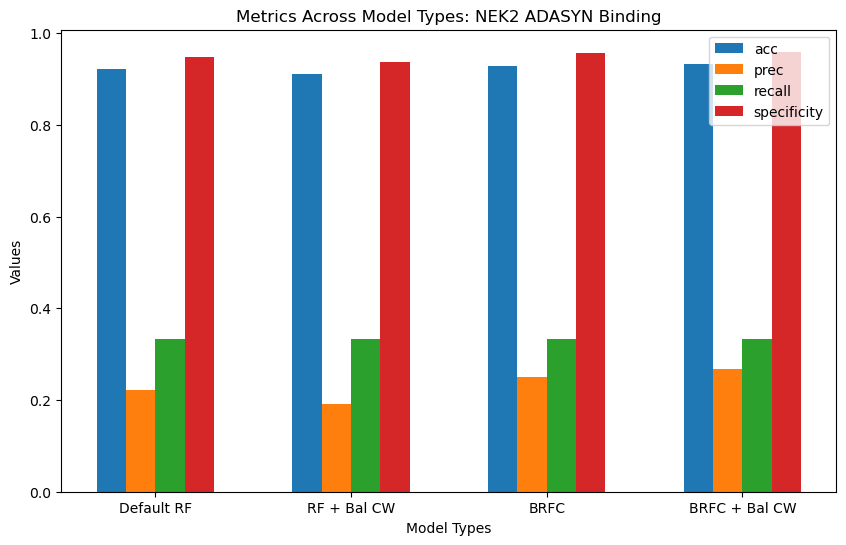

In [114]:
bind_adasyn_results = [] 
for model_type, model in bind_adasyn.items():
    results = rf_results2(model, train_x_ADASYN, train_y_ADASYN, test_x_ADASYN, test_y_ADASYN)
    bind_adasyn_results.append(results)
plot_metrics_for_models(bind_adasyn_results, 'NEK2 ADASYN Binding')

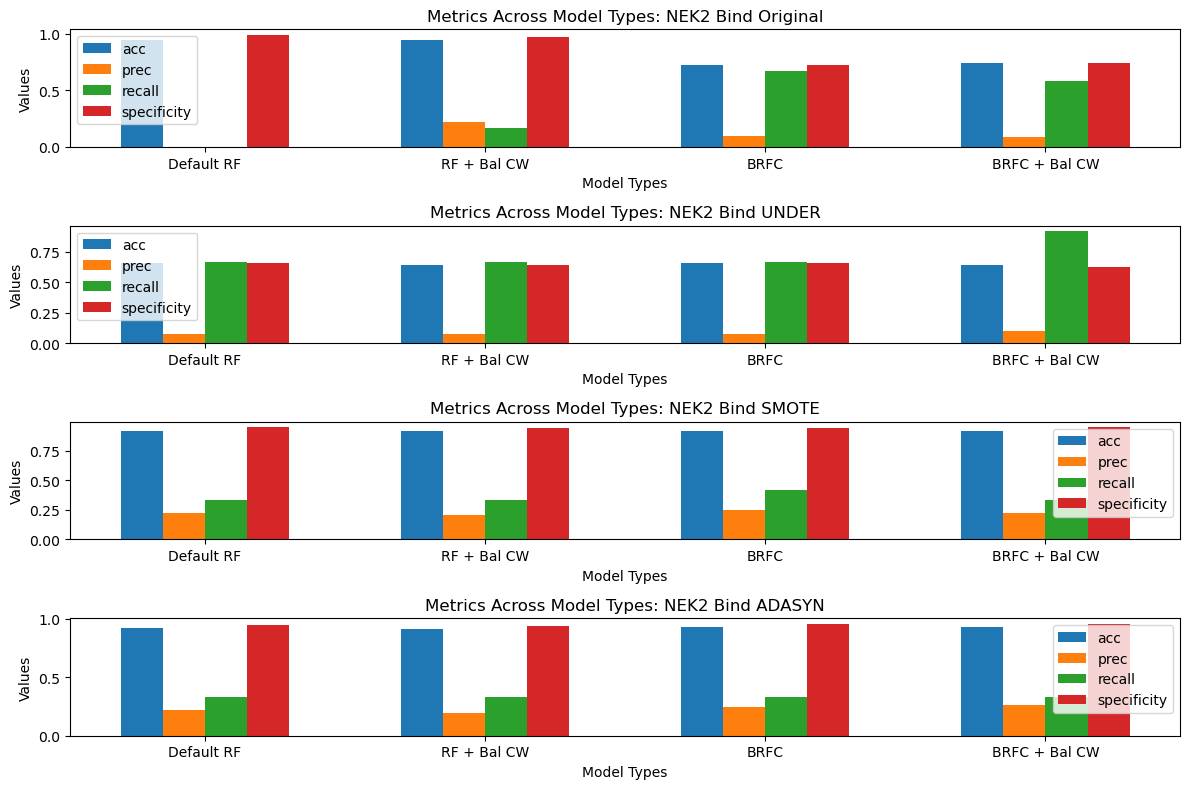

In [115]:
results_lists = [bind_original_results, bind_under_results, bind_smote_results, bind_adasyn_results]
dataset_titles = ['NEK2 Bind Original', 'NEK2 Bind UNDER', 'NEK2 Bind SMOTE', 'NEK2 Bind ADASYN']

plot_metrics_for_sampling(results_lists, dataset_titles)


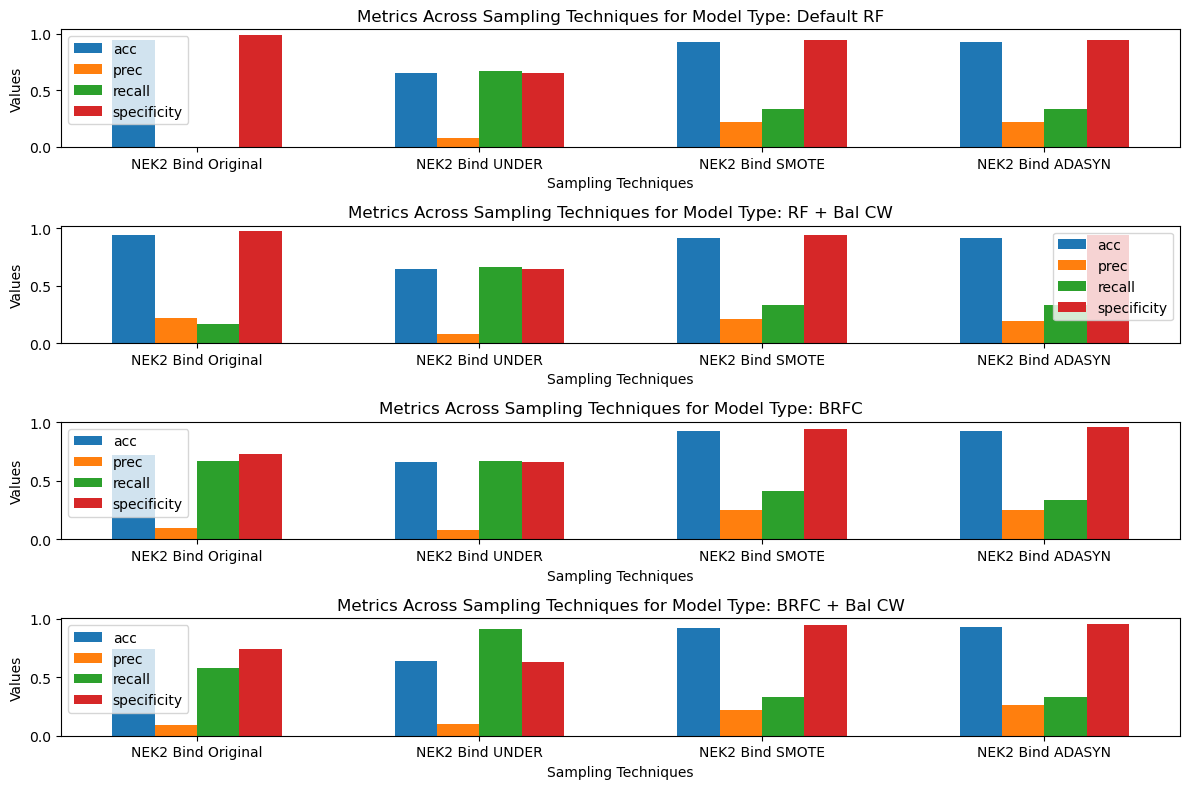

In [116]:
plot_metrics_for_models2(results_lists, dataset_titles)

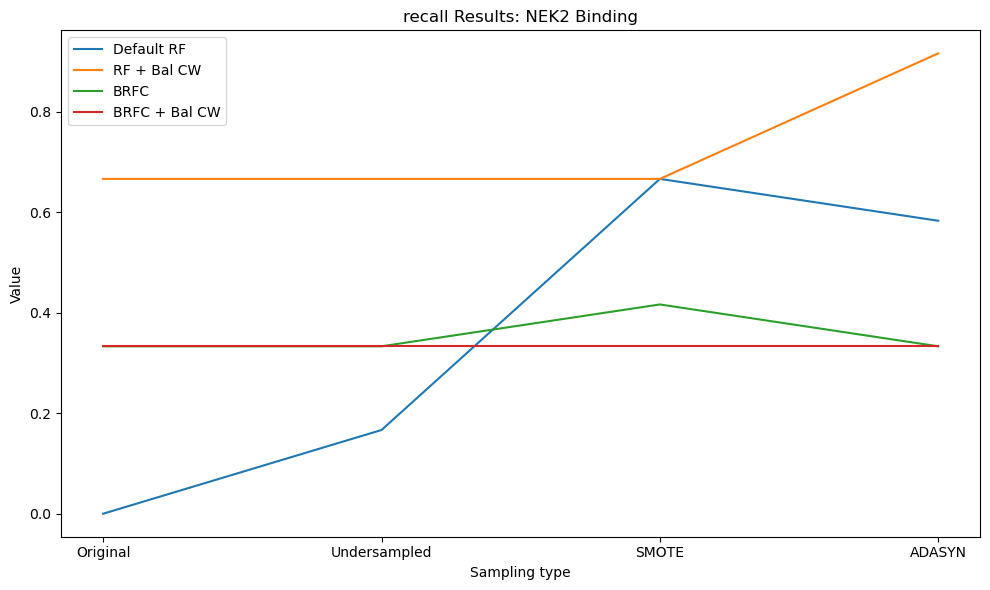

In [81]:
plot_chosen_metric(results_lists, 'recall', 'NEK2 Binding')

In [117]:
saved_results_all_datasets = []
sampling_types = ['Original', 'UNDER', 'SMOTE', 'ADASYN']
model_types = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
results_files = ['../nek2_bind_original_results.pkl','../nek2_bind_UNDER_results.pkl','../nek2_bind_SMOTE_results.pkl','../nek2_bind_ADASYN_results.pkl']
for i, results_file in enumerate(results_files):
    with open(results_file,'rb') as f:
        results = pickle.load(f)
        saved_results_all_datasets.append(results)
all_results_original1=saved_results_all_datasets[0]
all_results_under1 = saved_results_all_datasets[1] 
all_results_smote1 = saved_results_all_datasets[2]
all_results_adasyn1 =saved_results_all_datasets[3]
recall_original = [modeli['test_results']['recall'][0] for modeli in all_results_original1]
recall_under = [modeli['test_results']['recall'][0] for modeli in all_results_under1]
recall_smote = [modeli['test_results']['recall'][0] for modeli in all_results_smote1]
recall_adasyn= [modeli['test_results']['recall'][0] for modeli in all_results_adasyn1]

prec_original = [modeli['test_results']['precision'][0] for modeli in all_results_original1]
prec_under = [modeli['test_results']['precision'][0] for modeli in all_results_under1]
prec_smote =[modeli['test_results']['precision'][0] for modeli in all_results_smote1]
prec_adasyn = [modeli['test_results']['precision'][0] for modeli in all_results_adasyn1]

acc_original = [modeli['test_results']['accuracy'][0] for modeli in all_results_original1]
acc_under = [modeli['test_results']['accuracy'][0] for modeli in all_results_under1]
acc_smote = [modeli['test_results']['accuracy'][0] for modeli in all_results_smote1]
acc_adasyn = [modeli['test_results']['accuracy'][0] for modeli in all_results_adasyn1]

spec_original = [modeli['test_results']['specificity'][0] for modeli in all_results_original1]
spec_under = [modeli['test_results']['specificity'][0] for modeli in all_results_under1]
spec_smote = [modeli['test_results']['specificity'][0] for modeli in all_results_smote1]
spec_adasyn = [modeli['test_results']['specificity'][0] for modeli in all_results_adasyn1]



/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpick

In [118]:

with open('bind_rf_original_recall', 'wb') as f: 
    pickle.dump(recall_original, f)
with open('bind_rf_under_recall', 'wb') as f: 
    pickle.dump(recall_under, f) 
with open('bind_rf_smote_recall', 'wb') as f: 
    pickle.dump(recall_smote, f)
with open('bind_rf_adasyn_recall', 'wb') as f: 
    pickle.dump(recall_adasyn, f)

In [ ]:
gp_bind_metrics = 

In [ ]:
metrics = {'Accuracy': inhib_acc,'Precision': inhib_prec,'Recall': inhib_recall,'Specificity': inhib_spec}

def plot_metrics_for_models2(results_lists, titles):
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)

    bar_width = 0.15
    index = np.arange(num_models)
    for i in range(num_models):
        plt.subplot(num_models, 1, i+1)
        metric_values = np.zeros((num_datasets, num_metrics))
        for j, results_list in enumerate(results_lists):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results_list[i]['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Sampling Techniques')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Sampling Techniques for Model Type: {model_names[i]}')
        plt.xticks(index + bar_width * (num_metrics - 1) / 2, dataset_titles)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show();


In [96]:
# sampling = ['original', 'SMOTE', 'UNDER', 'ADASYN'] 
# plt.plot(inhib_acc, color='deepskyblue', label='MOE')
# plt.plot(morgan2inhib_acc, color='pink', label='Morgan FP')
# plt.xlabel('Sampling Technique')
# plt.ylabel('Recall Score')
# plt.title('NEK2 Inhibition GP Model Feature Comparison - Recall Scores')
# plt.xticks(range(len(sampling)), sampling)
# plt.tight_layout()
# plt.legend()
# plt.show()

[0.9888888888888889, 0.9740740740740741, 0.725925925925926, 0.7444444444444445]

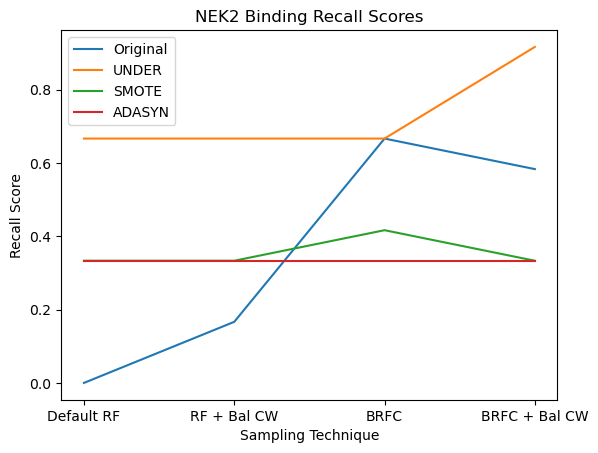

In [108]:
plt.plot(recall_original,label='Original')
plt.plot(recall_under,label='UNDER')
plt.plot(recall_smote,label='SMOTE')
plt.plot(recall_adasyn,label='ADASYN')
plt.xlabel('Sampling Technique')
plt.ylabel('Recall Score')
plt.xticks(range(4), model_types)
plt.title('NEK2 Binding Recall Scores')
plt.legend()
plt.show();

In [27]:
# default_results = []
# defaultbcw_results =[] 
# brfc_results = []
# brfcbcw_results = [] 
# recalls = []
# accuracies = []
# precisions = [] 
# specificities = [] 
# dataset_type_results2 = []
# model_types = []
# model_type_results = [] 

In [61]:

for i, results in enumerate(saved_results_all_datasets):
    model_type_results = []
    for model_type1of4 in results:
        model_type_results.append(model_type1of4['test_results'])
        
    for modelj in model_type_results:
        recall = modelj['recall'][0]
        precision = modelj['precision'][0]
        accuracy = modelj['accuracy'][0]
        specificity = modelj['specificity'][0]

        if i == 0:
            recall_original.append(recall)
            precision_original.append(precision)
            accuracy_original.append(accuracy)
            specificity_original.append(specificity)
        elif i == 1:
            recall_under.append(recall)
            precision_under.append(precision)
            accuracy_under.append(accuracy)
            specificity_under.append(specificity)
        elif i == 2:
            recall_smote.append(recall)
            precision_smote.append(precision)
            accuracy_smote.append(accuracy)
            specificity_smote.append(specificity)
        elif i == 3:
            recall_adasyn.append(recall)
            precision_adasyn.append(precision)
            accuracy_adasyn.append(accuracy)
            specificity_adasyn.append(specificity)

In [98]:
model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
metrics = ['accuracy', 'precision', 'recall', 'specificity']
num_metrics = len(metrics)
num_models = len(model_names)

metric_values = np.zeros((num_models, num_metrics))
for i, results in enumerate(results_list):
    for j, metric in enumerate(metrics):
        metric_values[i, j] = results['test_'+metric]
bar_width = 0.15
index = np.arange(num_models)
plt.figure(figsize=(10, 6))
for i in range(num_metrics):
    plt.bar(index + i*bar_width, metric_values[:,i], bar_width, label=metrics[i])

plt.xlabel('Model Types')
plt.ylabel('Values')
plt.title(f'Metrics Across Model Types: {dataset_title}')
plt.xticks(index +bar_width*(num_metrics - 1)/2, model_names)
plt.legend()
plt.show()

NameError: name 'results_list' is not defined